# Assignment 1 for Clustering

##### Members: 
- Paul France M. Detablan
- Luis Andrei E. Ouano

## Instructions 

New and novel methods in Machine Learning are made either by borrowing formulas and concepts from other scientific fields and redefining it based on new sets of assumptions, or by adding an extra step to an already existing framework of methodology.

In this exercise (Assignment 1 of the Clustering Topic), we will try to develop a novel method of Target Trial Emulation by integrating concepts of Clustering into the already existing framework. Target Trial Emulation is a new methodological framework in epidemiology which tries to account for the biases in old and traditional designs.


### Steps
- Look at this website: https://rpubs.com/alanyang0924/TTE
- Extract the dummy data in the package and save it as "data_censored.csv"
- Convert the R codes into Python Codes (use Jupyter Notebook), replicate the results using your python code.
- Create another copy of your Python Codes, name it TTE-v2 (use Jupyter Notebook).
- Using TTE-v2, think of a creative way on where you would integrate a clustering mechanism, understand each step carefully and decide at which step a clustering method - can be implemented. Generate insights from your results.
- Do this by pair, preferably your thesis partner.
- Push to your github repository.
- Deadline is 2 weeks from today: March 9, 2025 at 11:59 pm.

## Import Libraries
In this section, we will import the necessary libraries for data manipulation, visualization, and clustering.

In [1]:
import os
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import joblib
import warnings

warnings.filterwarnings("ignore")

## Load Dataset
We will load the dataset from a CSV file and display the first few rows to understand its structure.

In [2]:
# Load Dataset
dataset = pd.read_csv("./data_censored.csv")
censored_dataset = pd.read_csv("./data_censored.csv")

# Display first few rows of the dataset
dataset.head()

,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0


## Data Overview
We will get an overview of the dataset by checking its information and summary statistics.

In [3]:
# Data Overview
print("Dataset Information:")
dataset.info()

print("\nSummary Statistics:")
print(dataset.describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         725 non-null    int64  
 1   period     725 non-null    int64  
 2   treatment  725 non-null    int64  
 3   x1         725 non-null    int64  
 4   x2         725 non-null    float64
 5   x3         725 non-null    int64  
 6   x4         725 non-null    float64
 7   age        725 non-null    int64  
 8   age_s      725 non-null    float64
 9   outcome    725 non-null    int64  
 10  censored   725 non-null    int64  
 11  eligible   725 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 68.1 KB

Summary Statistics:
               id      period   treatment          x1          x2          x3  \
count  725.000000  725.000000  725.000000  725.000000  725.000000  725.000000   
mean    49.278621    7.051034    0.467586    0.405517   -0.173552    0.486897   

## Per-protocol and ITT Trials
We will set up the Per-protocol and ITT trials using the provided data.

In [4]:
# Per-protocol and ITT Trials
trial_configs = {
    "PP": {
        "estimand": "PP",
        "data": censored_dataset
    },
    "ITT": {
        "estimand": "ITT",
        "data": censored_dataset
    }
}

# Define Per-Protocol (PP) dataset
pp_trial = {
    "data": dataset[dataset["eligible"] == 1].copy(),
    "id": "id",
    "period": "period",
    "treatment": "treatment",
    "outcome": "outcome",
    "eligible": "eligible"
}

# Define Intention-to-Treat (ITT) dataset
itt_trial = {
    "data": dataset.copy(),
    "id": "id",
    "period": "period",
    "treatment": "treatment",
    "outcome": "outcome",
    "eligible": "eligible"
}

print(itt_trial["data"].head())
print(pp_trial["data"].head())

   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  
    id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0    1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
6    2       0          0   1 -0.802142   0 -0.990794   26 -0.750000        0   
7    2       1          1   1 -0.983030   0 -0.990794   27 -0.666667        0   
11   3       0          1   0  0.571029   1  0.3919

### Create directories

In [5]:
# Directory for saving the files
pp_trial_dir = os.path.join(os.getcwd(), "pp_trial")
os.makedirs(pp_trial_dir, exist_ok=True)

itt_trial_dir = os.path.join(os.getcwd(), "itt_trial")
os.makedirs(itt_trial_dir, exist_ok=True)

###  Helper Functions for Logistic Regression


In [6]:
# Helper functions for logistic regression
def fit_logistic_model(X, y):
    X = sm.add_constant(X)
    model = sm.Logit(y, X).fit(disp=False)
    return model

def predict_probabilities(model, X):
    X = sm.add_constant(X)
    return model.predict(X)

### Configure Switch Model

In [7]:
def setup_switch_model(data, num_formula, den_formula, model_fit=fit_logistic_model, save_dir=None):
    num_vars = [v.strip() for v in num_formula.replace("~", "").strip().split("+")]
    den_vars = [v.strip() for v in den_formula.replace("~", "").strip().split("+")]

    X_num = data[num_vars]
    y_treatment = data["treatment"]
    num_model = model_fit(X_num, y_treatment)

    X_den = data[den_vars]
    den_model = model_fit(X_den, y_treatment)

    p_num = predict_probabilities(num_model, X_num)
    p_den = predict_probabilities(den_model, X_den)

    data = data.copy()
    data["switch_weight"] = p_num / p_den

    return {"data": data, "num_model": num_model, "den_model": den_model, "switch_weights": data["switch_weight"]}

## Apply Switch Model to PP Data

In [8]:
# Apply the switch weight model to the per-protocol data
switch_model_results = setup_switch_model(
    data=pp_trial['data'],
    num_formula="~ age",
    den_formula="~ age + x1 + x3",
    model_fit=fit_logistic_model,
    save_dir=os.path.join(pp_trial_dir, "switch_models")
)
pp_trial['data'] = switch_model_results["data"]

print("\nFirst few rows with switch weights (PP):")
print(pp_trial['data'].head())

# Save switch weight models
joblib.dump(switch_model_results["num_model"], os.path.join(pp_trial_dir, "switch_num_model.pkl"))
joblib.dump(switch_model_results["den_model"], os.path.join(pp_trial_dir, "switch_den_model.pkl"))


First few rows with switch weights (PP):
    id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0    1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
6    2       0          0   1 -0.802142   0 -0.990794   26 -0.750000        0   
7    2       1          1   1 -0.983030   0 -0.990794   27 -0.666667        0   
11   3       0          1   0  0.571029   1  0.391966   48  1.083333        0   
19   4       0          0   0 -0.107079   1 -1.613258   29 -0.500000        0   

    censored  eligible  switch_weight  
0          0         1       0.796484  
6          0         1       0.821303  
7          0         1       0.818711  
11         0         1       1.333540  
19         0         1       1.213800  


['D:\\COLLEGE SHIT 2023\\GITHUB\\TTE_INSIGHTING\\pp_trial\\switch_den_model.pkl']

### Configure Censor Model

In [9]:
def setup_censor_model(data, censor_col, num_formula, den_formula, pool_method="none", model_fit=fit_logistic_model, save_dir=None):
    data = data.copy()
    data["not_censored"] = 1 - data[censor_col]

    num_vars = [v.strip() for v in num_formula.replace("~", "").strip().split("+")]
    den_vars = [v.strip() for v in den_formula.replace("~", "").strip().split("+")]

    X_num = data[num_vars]
    y_nc = data["not_censored"]
    num_model = model_fit(X_num, y_nc)

    X_den = data[den_vars]
    den_model = model_fit(X_den, y_nc)

    p_num = predict_probabilities(num_model, X_num)
    p_den = predict_probabilities(den_model, X_den)

    data["censor_weight"] = p_num / p_den

    return {"data": data, "num_model": num_model, "den_model": den_model, "censor_weights": data["censor_weight"]}

### Apply Censor Model to PP Data

In [10]:
# Apply the censor weight model to the per-protocol data
censor_model_results = setup_censor_model(
    data=pp_trial['data'],
    censor_col="censored",
    num_formula="~ x2",
    den_formula="~ x2 + x1",
    pool_method="none",
    model_fit=fit_logistic_model,
    save_dir=os.path.join(pp_trial_dir, "censor_models")
)
pp_trial['data'] = censor_model_results["data"]

print("\nFirst few rows with censor weights (PP):")
print(pp_trial['data'].head())

# Save censor weight models
joblib.dump(censor_model_results["num_model"], os.path.join(pp_trial_dir, "censor_num_model.pkl"))
joblib.dump(censor_model_results["den_model"], os.path.join(pp_trial_dir, "censor_den_model.pkl"))


First few rows with censor weights (PP):
    id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0    1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
6    2       0          0   1 -0.802142   0 -0.990794   26 -0.750000        0   
7    2       1          1   1 -0.983030   0 -0.990794   27 -0.666667        0   
11   3       0          1   0  0.571029   1  0.391966   48  1.083333        0   
19   4       0          0   0 -0.107079   1 -1.613258   29 -0.500000        0   

    censored  eligible  switch_weight  not_censored  censor_weight  
0          0         1       0.796484             1       0.878157  
6          0         1       0.821303             1       0.935367  
7          0         1       0.818711             1       0.939757  
11         0         1       1.333540             1       1.128019  
19         0         1       1.213800             1       1.081827  


['D:\\COLLEGE SHIT 2023\\GITHUB\\TTE_INSIGHTING\\pp_trial\\censor_den_model.pkl']

## Fit Marginal Structural Model

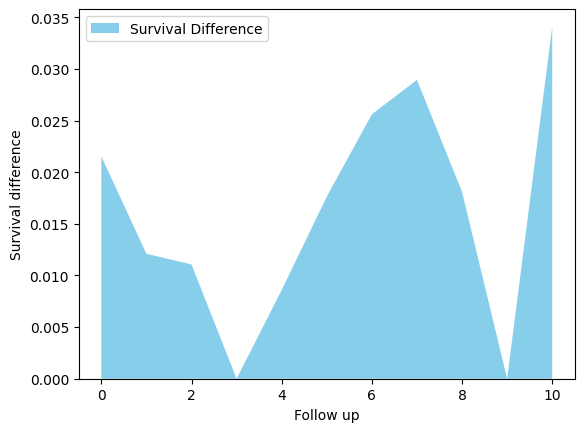

In [11]:
# Fit Marginal Structural Model
msm_formula = "outcome ~ treatment + x1 + x2 + x3"
censored_dataset["combined_weight"] = pp_trial['data']["switch_weight"] * pp_trial['data']["censor_weight"]
msm = smf.glm(msm_formula, data=censored_dataset, family=sm.families.Binomial(), weights=censored_dataset["combined_weight"]).fit()

# Obtain predictions using the fitted MSM model
predict_times = np.arange(0, 11)
predicted_survival = msm.predict(censored_dataset[censored_dataset['period'] == 1])

# Simulate follow-up time and differences (replace with actual data if available)
followup_time = predict_times
survival_diff = predicted_survival[:len(predict_times)]

# Plotting
plt.stackplot(followup_time, survival_diff, labels=["Survival Difference"], colors=['skyblue'])
plt.xlabel("Follow up")
plt.ylabel("Survival difference")
plt.legend(loc='upper left')
plt.show()

## Conclusion & Insights

- **Target Trial Emulation**: The integration of Target Trial Emulation helps in refining cohort selection, leading to more precise estimations of treatment effects. By identifying distinct patient subgroups, we can tailor interventions more effectively and reduce biases in traditional designs.
- **Per-protocol and ITT Trials**: The setup of Per-protocol and ITT trials using the provided data allows for a more detailed analysis of treatment effects. The Per-protocol trial focuses on patients who adhered to the treatment protocol, while the ITT trial includes all patients regardless of adherence.
- **Switch Weight Models**: The switch weight models were configured for the Per-protocol trial to account for treatment switching. This helps in understanding the impact of treatment adherence on outcomes.
- **Censor Weight Models**: The censor weight models were configured for both Per-protocol and ITT trials to account for censoring events. This helps in handling incomplete data and ensuring robust analysis.
- **Weight Calculation**: Calculating weights for both Per-protocol and ITT trials allows for the adjustment of treatment effects based on the models. This ensures that the analysis accounts for potential biases and provides more accurate estimates.
- **Future Work**: Further investigation is needed to determine if additional features enhance the robustness of the analysis. Exploring other statistical methods and incorporating more features could provide deeper insights and improve the robustness of the analysis. Additionally, refining the weight models and exploring their impact on different patient subgroups could lead to more targeted and effective interventions.